In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from plotnine import *

In [2]:
d = pd.read_csv('rank_runs_summary.csv')

d

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training lists,test lists,data_size,test_size,run_i,rand_seed
0,uci wine example,Stan inspection model,0.481229,0.474121,0.566175,0.537973,100,100,6497,6015,0,682143856
1,uci wine example,Stan utility model,0.484121,0.476511,0.777750,0.376688,100,100,6497,6015,0,682143856
2,uci wine example,logistic,0.491947,0.484366,0.772338,0.429960,100,100,6497,6015,0,682143856
3,uci wine example,observed score,0.525406,0.516799,0.592825,0.458141,100,100,6497,6015,0,682143856
4,uci wine example,Stan inspection model,0.367689,0.366153,0.597137,inf,100,100,6497,6018,1,664543176
...,...,...,...,...,...,...,...,...,...,...,...,...
75,uci wine example,observed score,0.510695,0.507131,0.604975,0.458491,100,100,6497,6015,18,1718405262
76,uci wine example,Stan inspection model,0.382216,0.378138,0.543950,0.514386,100,100,6497,6018,19,1324584049
77,uci wine example,Stan utility model,0.377593,0.373463,0.725738,0.407781,100,100,6497,6018,19,1324584049
78,uci wine example,logistic,0.373630,0.369088,0.715313,0.444783,100,100,6497,6018,19,1324584049


In [3]:
n_draws = int(np.max(d['run_i']) + 1)

In [4]:
d_SpearmanR = d.melt(
    id_vars=['example_name', 'estimate_name'],
    value_vars=['SpearmanR_all', 'SpearmanR_test'],
    var_name='measurement',
    value_name='Spearman R',
)

d_SpearmanR

,example_name,estimate_name,measurement,Spearman R
0,uci wine example,Stan inspection model,SpearmanR_all,0.481229
1,uci wine example,Stan utility model,SpearmanR_all,0.484121
2,uci wine example,logistic,SpearmanR_all,0.491947
3,uci wine example,observed score,SpearmanR_all,0.525406
4,uci wine example,Stan inspection model,SpearmanR_all,0.367689
...,...,...,...,...
155,uci wine example,observed score,SpearmanR_test,0.507131
156,uci wine example,Stan inspection model,SpearmanR_test,0.378138
157,uci wine example,Stan utility model,SpearmanR_test,0.373463
158,uci wine example,logistic,SpearmanR_test,0.369088


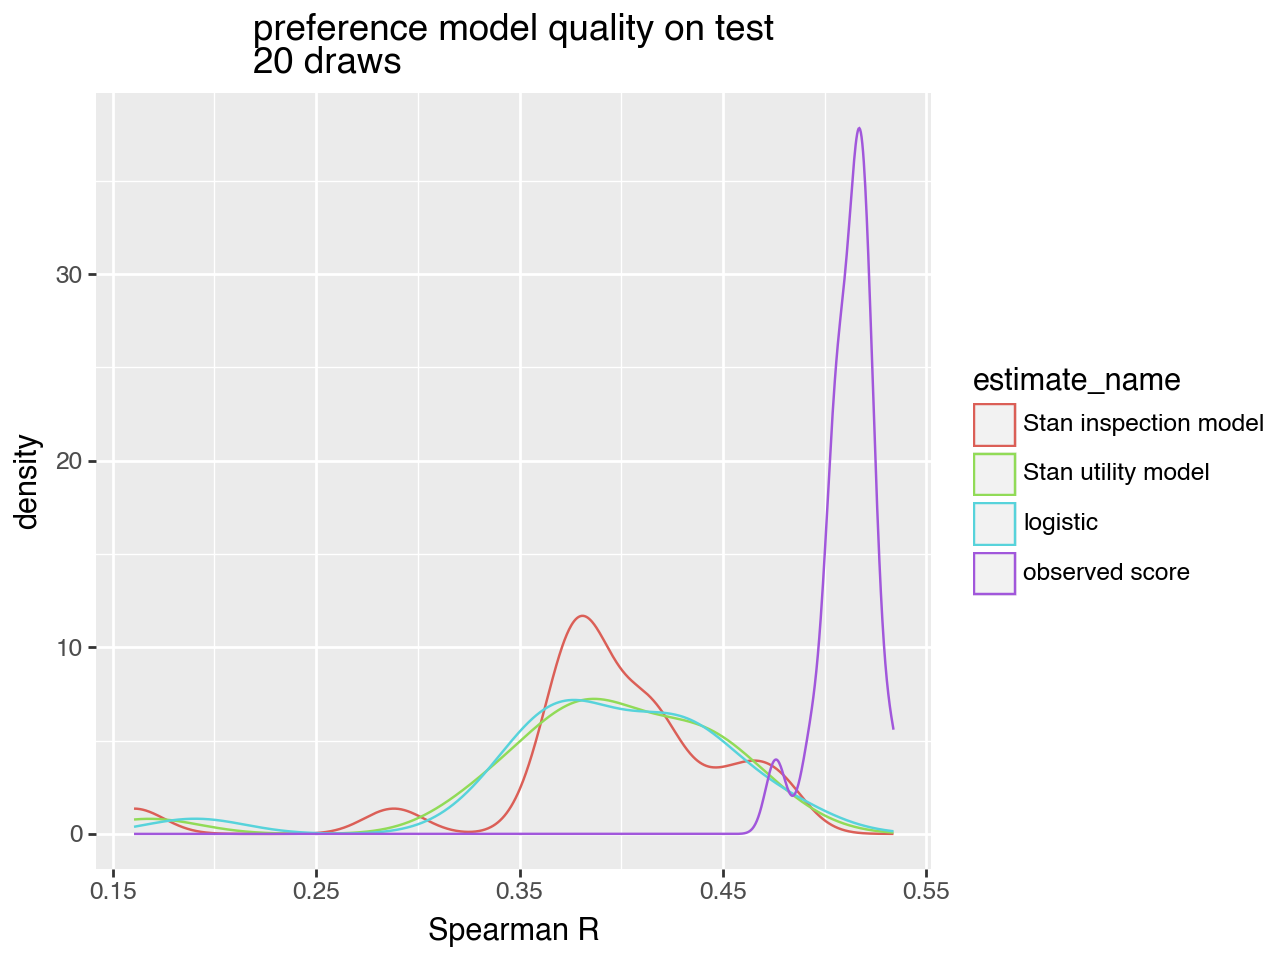

In [5]:
(
    ggplot(
        data=d_SpearmanR.loc[d_SpearmanR['measurement'] == 'SpearmanR_test', :],
        mapping=aes(
            x='Spearman R',
            color='estimate_name',
        )
    )
    + geom_density()
    + ggtitle(f"preference model quality on test\n{n_draws} draws")
)

In [6]:
estimate_names = sorted(set(d['estimate_name']))

estimate_names

['Stan inspection model', 'Stan utility model', 'logistic', 'observed score']

Stan inspection model


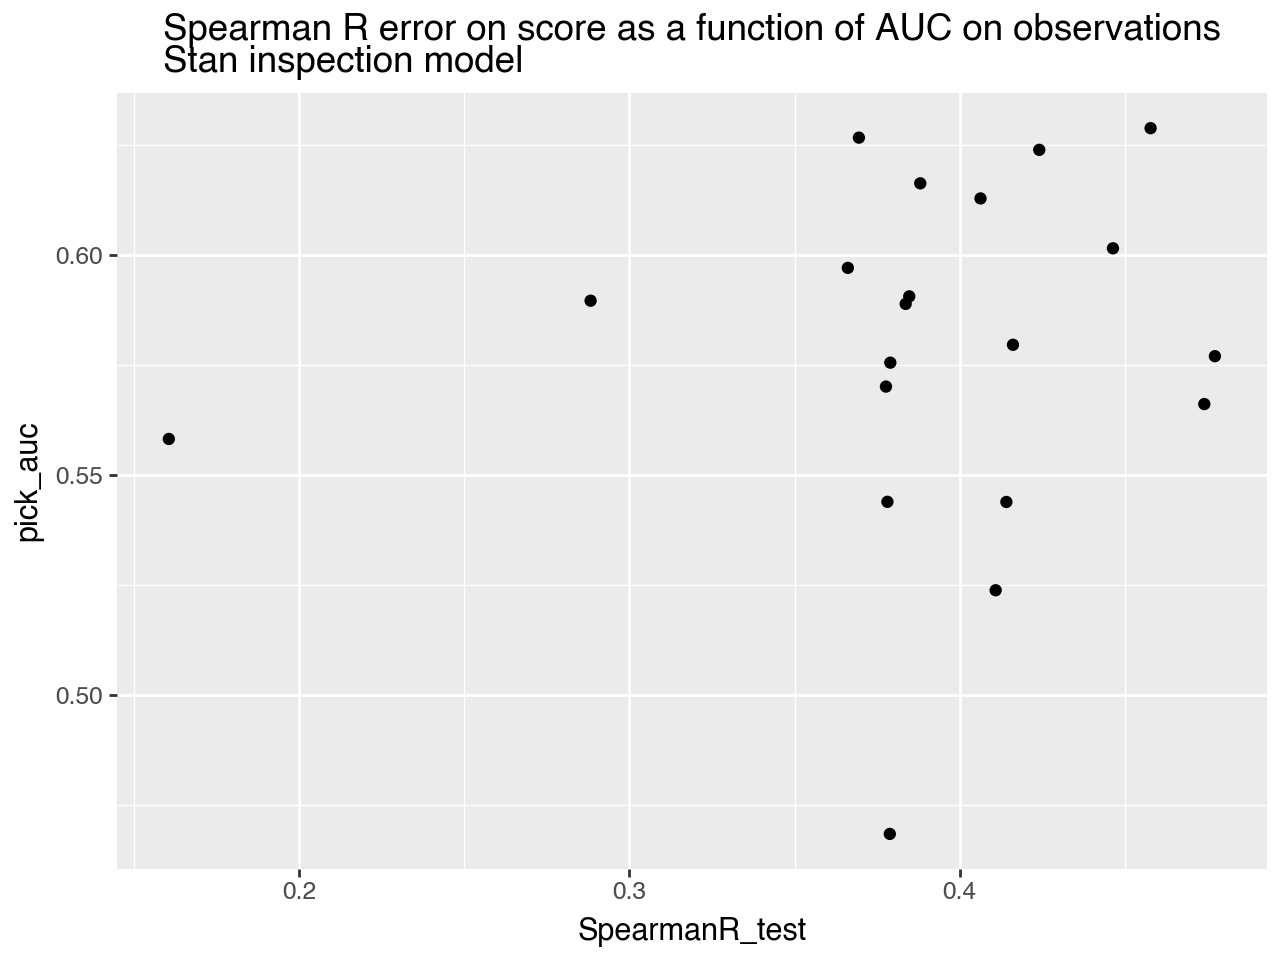

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.3839
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.543
Time:                        20:19:41   Log-Likelihood:                 25.841
No. Observations:                  20   AIC:                            -47.68
Df Residuals:                      18   BIC:                            -45.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2413      0.239      1.009      0.326      -0.261       0.744
pick_auc       0.2552      0.412      0.620      0.543      -0.610       1.120
==============================================================================
Omnibus:                       19.612   Durbin-Watson:                   1.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.144
Skew:                          -1.782   Prob(JB):                     5.72e-06
Kurtosis:                       7.033   Cond. No.                         35.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Stan utility model


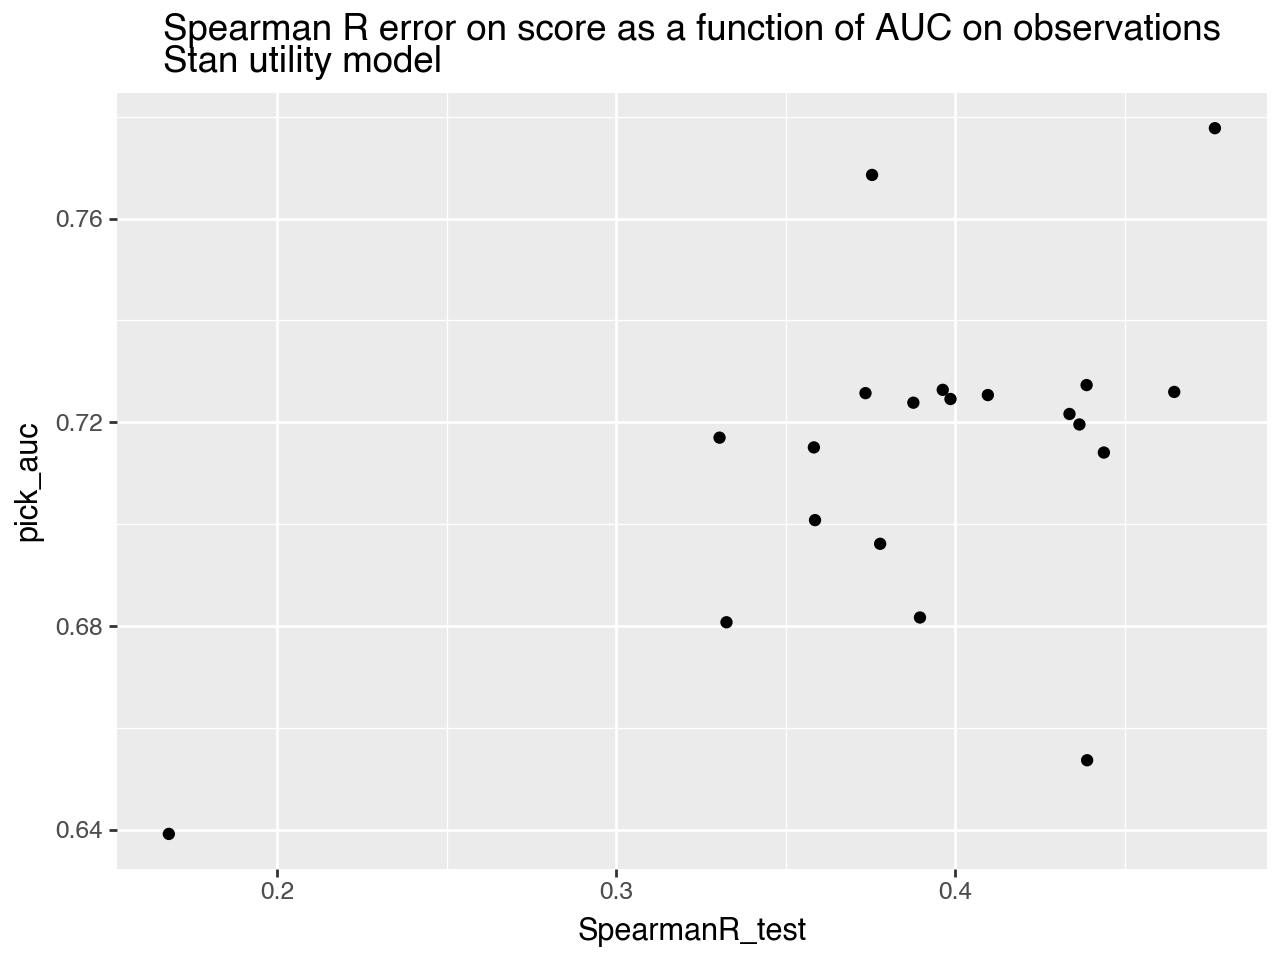

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     8.323
Date:                Thu, 29 Aug 2024   Prob (F-statistic):            0.00986
Time:                        20:19:41   Log-Likelihood:                 30.146
No. Observations:                  20   AIC:                            -56.29
Df Residuals:                      18   BIC:                            -54.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4336      0.286     -1.518      0.146      -1.033       0.166
pick_auc       1.1538      0.400      2.885      0.010       0.314       1.994
==============================================================================
Omnibus:                        2.479   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                0.907
Skew:                          -0.358   Prob(JB):                        0.635
Kurtosis:                       3.758   Cond. No.                         47.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

logistic


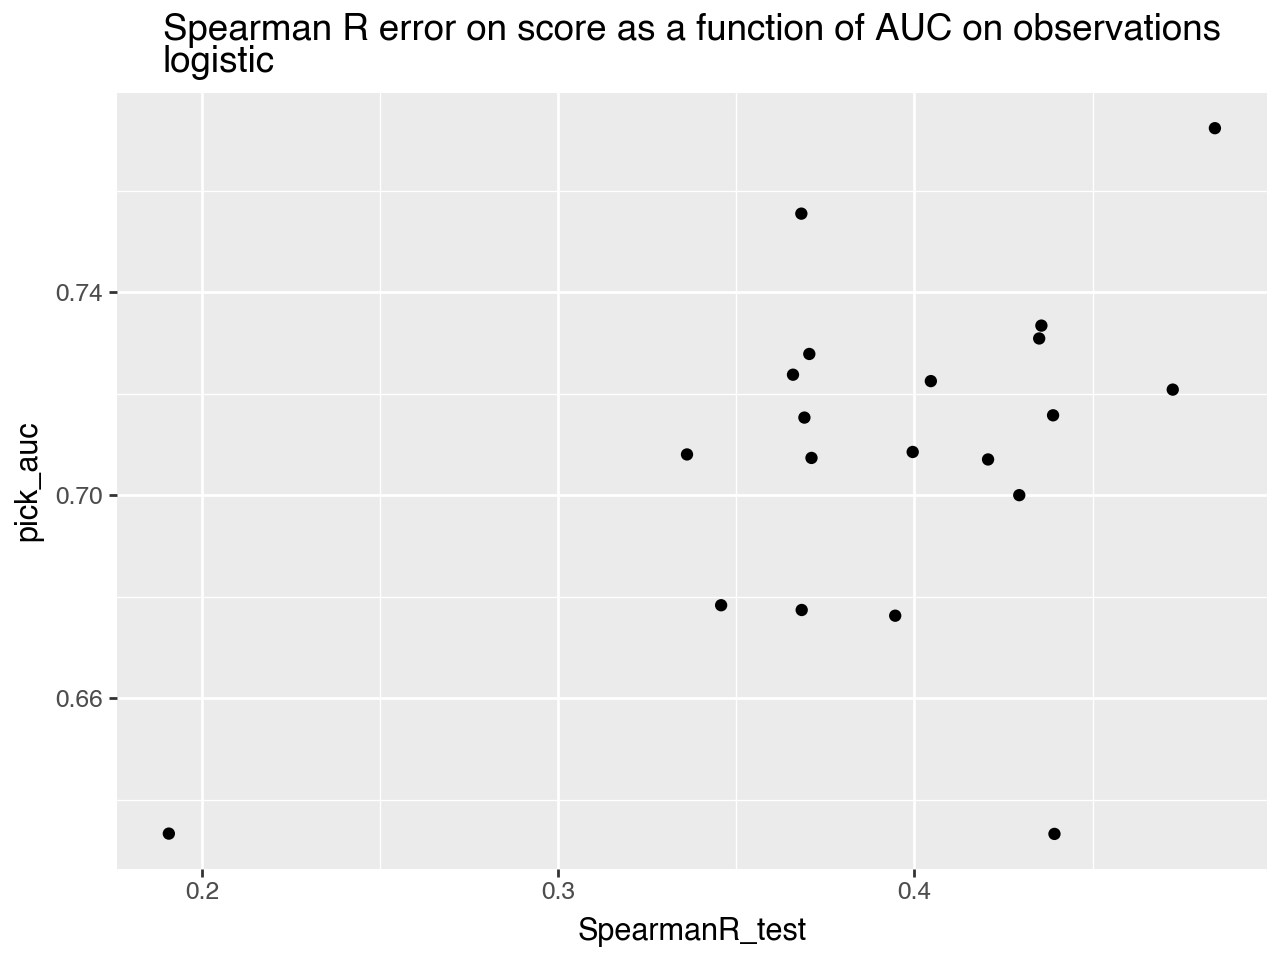

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     6.062
Date:                Thu, 29 Aug 2024   Prob (F-statistic):             0.0241
Time:                        20:19:41   Log-Likelihood:                 30.422
No. Observations:                  20   AIC:                            -56.84
Df Residuals:                      18   BIC:                            -54.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2516      0.262     -0.962      0.349      -0.801       0.298
pick_auc       0.9099      0.370      2.462      0.024       0.133       1.686
==============================================================================
Omnibus:                        2.084   Durbin-Watson:                   1.400
Prob(Omnibus):                  0.353   Jarque-Bera (JB):                0.688
Skew:                          -0.334   Prob(JB):                        0.709
Kurtosis:                       3.615   Cond. No.                         44.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

observed score


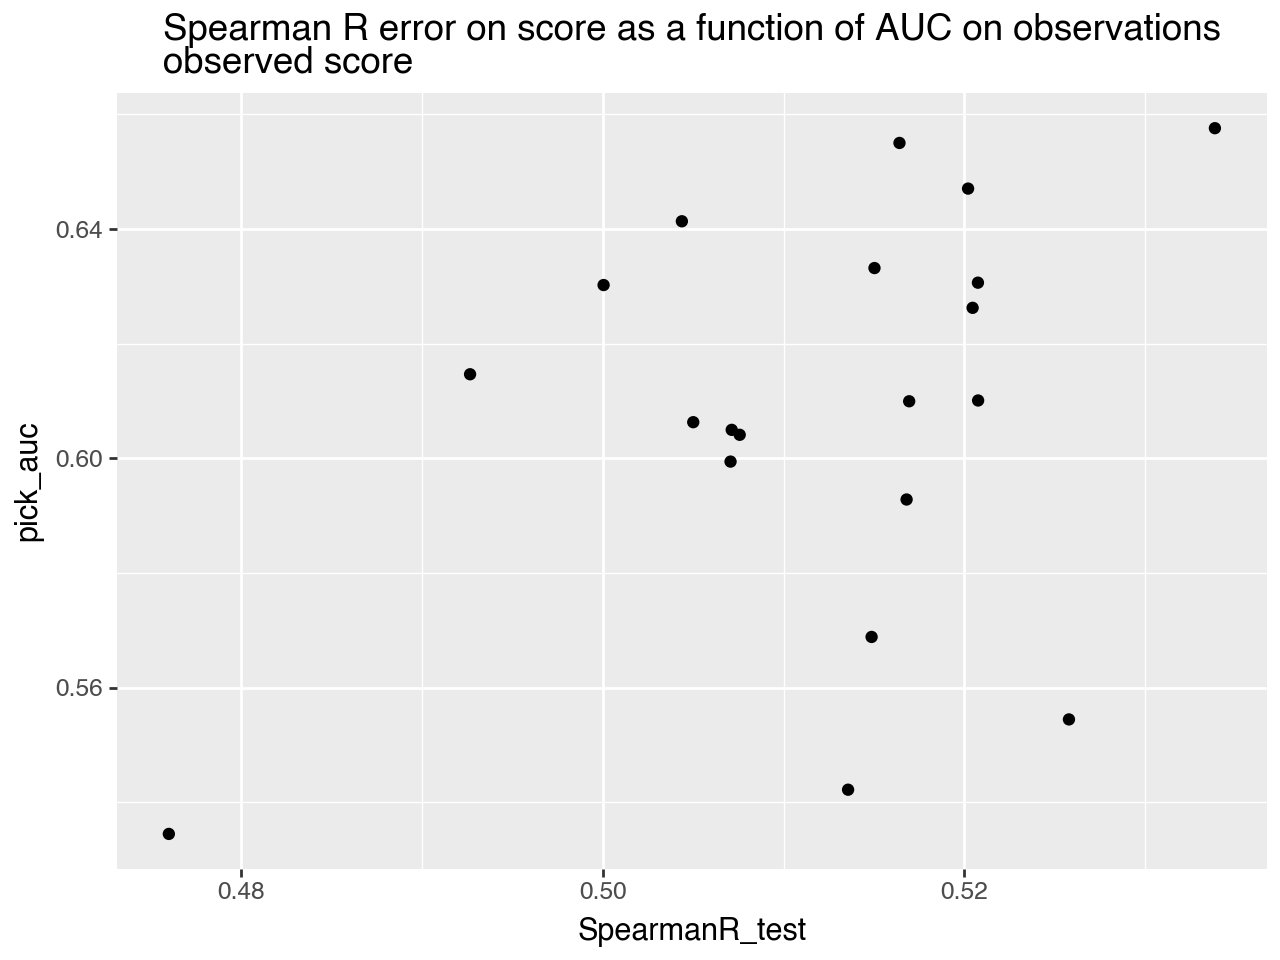

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.819
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.110
Time:                        20:19:41   Log-Likelihood:                 61.023
No. Observations:                  20   AIC:                            -118.0
Df Residuals:                      18   BIC:                            -116.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4319      0.048      9.066      0.000       0.332       0.532
pick_auc       0.1313      0.078      1.679      0.110      -0.033       0.296
==============================================================================
Omnibus:                        1.262   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                0.786
Skew:                          -0.478   Prob(JB):                        0.675
Kurtosis:                       2.832   Cond. No.                         39.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
for estimate_name in estimate_names:
    di = d.loc[d['estimate_name'] == estimate_name, :]
    print(estimate_name)
    (
        ggplot(
            data=di,
            mapping=aes(x='SpearmanR_test', y='pick_auc')
        )
        + geom_point()
        + ggtitle(f"Spearman R error on score as a function of AUC on observations\n{estimate_name}")
    ).show()
    model = ols(
        'SpearmanR_test ~ 1 + pick_auc',
        data=di,
    ).fit()
    display(model.summary())